# Imports

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [18]:
import time
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import copy

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [41]:
DATA_DIR = Path('EyesDataset/')
files = sorted(list(DATA_DIR.rglob('*.jpg')))
train_files, test_files = train_test_split(files, test_size=0.1)

In [12]:
DATA_MODES = ['train', 'test']
DEVICE = torch.device("cuda")

# K-means

In [13]:
TEST_SIZE = 500 

In [14]:
def load_sample(file):
    image = Image.open(file)
    image.load()
    return (np.array(image)/255).flatten()

In [15]:
X_train = np.array([load_sample(x) for x in train_files])
X_test = np.array([load_sample(x) for x in test_files])

In [23]:
def show_results(model, X_features):
    ind = np.random.randint(len(X_features), size=20)
    features = X_features[ind]
    images = X_test[ind]
    labs = model.predict(features)
    images = (255 * images).astype(int)
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1].reshape(24,24), cmap='gray')
        plt.title(labs[i-1])
    plt.show()

In [24]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

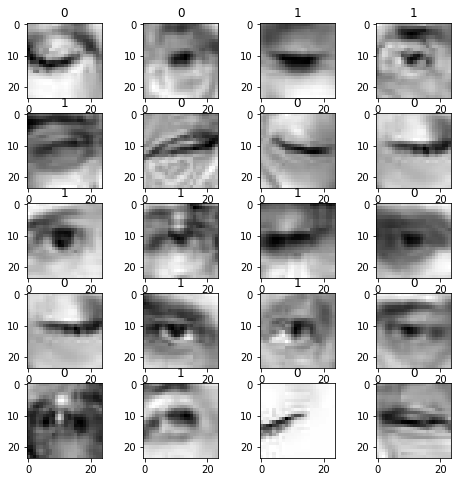

In [25]:
show_results(kmeans, X_test)

# PCA + k-means

In [26]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

In [27]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [28]:
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(X_train_pca)

In [29]:
labels = kmeans_pca.predict(X_test_pca)

In [30]:
centers = kmeans_pca.cluster_centers_

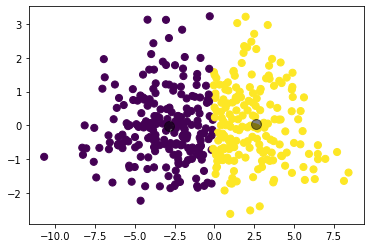

In [32]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=labels,
            s=50, cmap='viridis')
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)


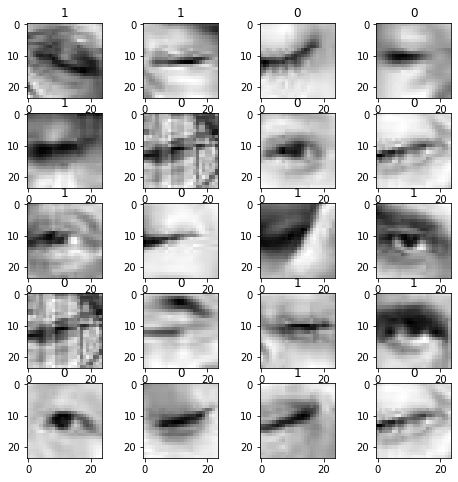

In [33]:
show_results(kmeans_pca, X_test_pca)

# Deep approach

In [52]:
class EyesDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(24, scale=(0.8, 1), ratio=(0.75, 1.3333333333333333), interpolation=2),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.9, interpolation=3, fill=0),
            transforms.RandomAffine(degrees=20, shear=20, resample=False),
            transforms.Resize((24, 24))
        ])
        
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = augmentation(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        return x
        
    def _prepare_sample(self, image):
        image = image.resize((24, 24))
        return np.array(image)

In [125]:
train_dataset = EyesDataset(train_files, mode='train')
test_dataset = EyesDataset(test_files, mode='test')

In [126]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=16)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=16)

In [89]:
class VAE(nn.Module):
    def __init__(self, dim_code=100):
        super(VAE, self).__init__()
        self.begin_encoder = nn.Sequential(
            nn.Linear(24 * 24, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
        )
        self.latent1 = nn.Linear(250, dim_code)
        self.latent2 = nn.Linear(250, dim_code)
        self.begin_decoder = nn.Sequential(
            nn.Linear(dim_code, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(500, 24 * 24),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.begin_encoder(x)
        mu = self.latent1(x)
        logsigma = self.latent2(x)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = logsigma.exp()
            eps = torch.randn_like(std)
            return eps.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, z):
        z = self.begin_decoder(z)
        reconstruction = self.out(z)        
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [84]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + 2 * logsigma - mu * mu - torch.exp(2 * logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss()
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    c = x.size(0) * x.size(1)
    return KL_divergence(mu, logsigma) / c + log_likelihood(x, reconstruction)

In [146]:
def plot_eyes(sam1, sam2):
    sam1 = sam1.cpu().detach().numpy()
    sam2 = sam2.cpu().detach().numpy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].imshow(sam1.reshape(24,24), cmap='gray')
    axes[1].imshow(sam2.reshape(24,24), cmap='gray')
    fig.tight_layout()

И обучим модель:

In [111]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for train_x in train_loader:
        train_x = train_x[0].to(DEVICE)
        train_x = train_x.view(-1, 24 * 24)
        # zero  gradients
        optimizer.zero_grad()

        # get the output from the model
        mu, logsigma, reconstruction = net(train_x)
        
        # calculate loss
        loss = loss_fn(train_x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1
    train_ep_loss /= counter
   
    return train_ep_loss

In [141]:
def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for test_x in test_loader:
        # get the output from the model
        test_x = test_x.to(DEVICE)
        test_x = test_x.view(-1, 24 * 24)

        mu, logsigma, reconstruction = net(test_x)
        
        # calculate loss
        
        loss = loss_fn(test_x, mu, logsigma, reconstruction)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter
    plot_eyes(test_x[0], reconstruction[0])

    return test_ep_loss

In [142]:
def train(net, train_loader, test_loader, loss_fn, optimizer, epochs, scheduler=None):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        if scheduler:
            scheduler.step()
        with torch.no_grad():
            test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)


        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

In [147]:
vae = VAE().to(DEVICE)

optimizer = torch.optim.Adam(vae.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2)
criterion = loss_vae

In [148]:
vae_train_losses, vae_test_losses = train(vae, train_loader, test_loader, criterion, optimizer, 20, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`
Exception raised from gemm<float> at /pytorch/aten/src/ATen/cuda/CUDABlas.cpp:165 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7fba290071e2 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0xefd203 (0x7fba2a13c203 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #2: at::native::(anonymous namespace)::addmm_out_cuda_impl(at::Tensor&, at::Tensor const&, at::Tensor const&, at::Tensor const&, c10::Scalar, c10::Scalar) + 0xf15 (0x7fba2b226145 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #3: at::native::mm_cuda(at::Tensor const&, at::Tensor const&) + 0xb3 (0x7fba2b228043 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #4: <unknown function> + 0xf22a20 (0x7fba2a161a20 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0xa56530 (0x7fba64895530 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #6: at::Tensor c10::Dispatcher::call<at::Tensor, at::Tensor const&, at::Tensor const&>(c10::TypedOperatorHandle<at::Tensor (at::Tensor const&, at::Tensor const&)> const&, at::Tensor const&, at::Tensor const&) const + 0xbc (0x7fba6507d81c in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #7: at::mm(at::Tensor const&, at::Tensor const&) + 0x4b (0x7fba64fce6ab in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x2ed0a2f (0x7fba66d0fa2f in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #9: <unknown function> + 0xa56530 (0x7fba64895530 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::Tensor c10::Dispatcher::call<at::Tensor, at::Tensor const&, at::Tensor const&>(c10::TypedOperatorHandle<at::Tensor (at::Tensor const&, at::Tensor const&)> const&, at::Tensor const&, at::Tensor const&) const + 0xbc (0x7fba6507d81c in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #11: at::Tensor::mm(at::Tensor const&) const + 0x4b (0x7fba65163cab in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0x2d11fbb (0x7fba66b50fbb in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #13: torch::autograd::generated::AddmmBackward::apply(std::vector<at::Tensor, std::allocator<at::Tensor> >&&) + 0x2a0 (0x7fba66b56bc0 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x3375bb7 (0x7fba671b4bb7 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #15: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x1400 (0x7fba671b0400 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #16: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7fba671b0fa1 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7fba671a9119 in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_cpu.so)
frame #18: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7fba80d6886a in /home/philipp/Work/polyvore/venv/lib/python3.8/site-packages/torch/lib/libtorch_python.so)
frame #19: <unknown function> + 0xd6cb4 (0x7fba93ce0cb4 in /lib/x86_64-linux-gnu/libstdc++.so.6)
frame #20: <unknown function> + 0x9609 (0x7fba96f8e609 in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #21: clone + 0x43 (0x7fba970ca103 in /lib/x86_64-linux-gnu/libc.so.6)
